In [82]:
from __future__ import annotations
import numpy as np
import itertools
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from scipy.optimize import linprog
from typing import Dict, List, Optional, Tuple, Iterable
from scipy.optimize import linprog
import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')


# Region class

In [83]:
# Region class as dataclass
class Region:
    def __init__(self, activation=None):
        # Region attributes
        self.q = activation # Activation pattern
        self.q_tilde = None # Active bits in activation pattern (indices)
        self.ineqs = None # Inequalities in the form [A c] #TODO -c?
        
        # Tree attributes
        self.parent = None # Parent Region object
        self.children = [] # List of children (Region objects)
        
        # Utility attributed
        self.layer_number = 0 # Layer to which this region belongs
        self.region_index = 0 # Index to identify regions #TODO necessary?
        
    def add_child(self, child):
        child.parent = self
        self.children.append(child)
        
    def is_leaf(self):
        return len(self.children) == 0
    
    def is_root(self):
        return self.parent is None
    
    def get_children(self):
        return self.children
    
    def get_depth(self):
        depth = 0
        node = self
        while node.parent is not None:
            node = node.parent
            depth += 1
        assert depth == self.layer_number, "Depth and layer number are not equal"
        return depth
    
    def get_ancestors(self):
        ancestors = []
        node = self
        
        while node.parent is not None:
            ancestors.append(node.parent)
            node = node.parent
        
        return ancestors[::-1]
    
    def get_path_inequalitites(self):
        inequalities = []
        node = self
        
        while node.parent is not None:
            if node.ineqs is not None:
                inequalities.append(node.ineqs)
            node = node.parent
            
        return np.vstack(inequalities[::-1]) if inequalities else None
        
        

# Logic begin building the tree

## Make state dict

In [84]:
# Make a dummy state dict
from src_experiment import NeuralNet

model = NeuralNet(
    input_size = 2,
    hidden_sizes = [5,3],
    num_classes=2,
    seed=3,
)
sd = model.state_dict()
sd

OrderedDict([('l1.weight',
              tensor([[-1.7173, -1.3663],
                      [-0.7419, -1.6387],
                      [-0.0983, -1.5238],
                      [ 0.9418,  0.8442],
                      [ 0.3271,  1.3436]])),
             ('l1.bias', tensor([0., 0., 0., 0., 0.])),
             ('l2.weight',
              tensor([[-0.1073,  0.6562, -0.7672, -0.2159, -0.9767],
                      [-0.0889, -0.7107,  0.9841,  0.7609,  0.8213],
                      [ 0.3249, -0.6249,  0.9844, -1.0689, -0.6992]])),
             ('l2.bias', tensor([0., 0., 0.])),
             ('l3.weight',
              tensor([[-0.6842, -0.4541,  0.2184],
                      [-0.8298, -0.8439, -0.5239]])),
             ('l3.bias', tensor([0., 0.]))])

## Find the hyperplanes

In [85]:
def find_hyperplanes(state_dict):
    weights = []
    biases = []
    hyperplanes = [] 
    for key, val in state_dict.items():
        if "weight" in key:
            weights.append(val)
        elif "bias" in key:
            biases.append(val)
    for W, b in zip(weights, biases):
        hyperplanes.append(np.hstack((W, b.reshape(-1,1))))
    return hyperplanes
H = find_hyperplanes(sd)

## Extract $W$ and $b$ and find $x_0$ "random" point

In [86]:
# For the first step, the root node is the parent, it should be initializes without an activation pattern

# Root initialization
root = Region()

# Work with the first layer - regions induced by the first layer of the network
# Weigths and biases of first layer
W1, b1 = H[1-1][:,:-1], H[1-1][:,-1].reshape(-1,1)

# "random" point in input space x0 has shape (d_input, 1)
x0 = np.random.randint(-3,3,size=W1[0,:].shape).reshape(-1,1)
x0

array([[-1],
       [-3]])

## Visualize hyperplanes and points

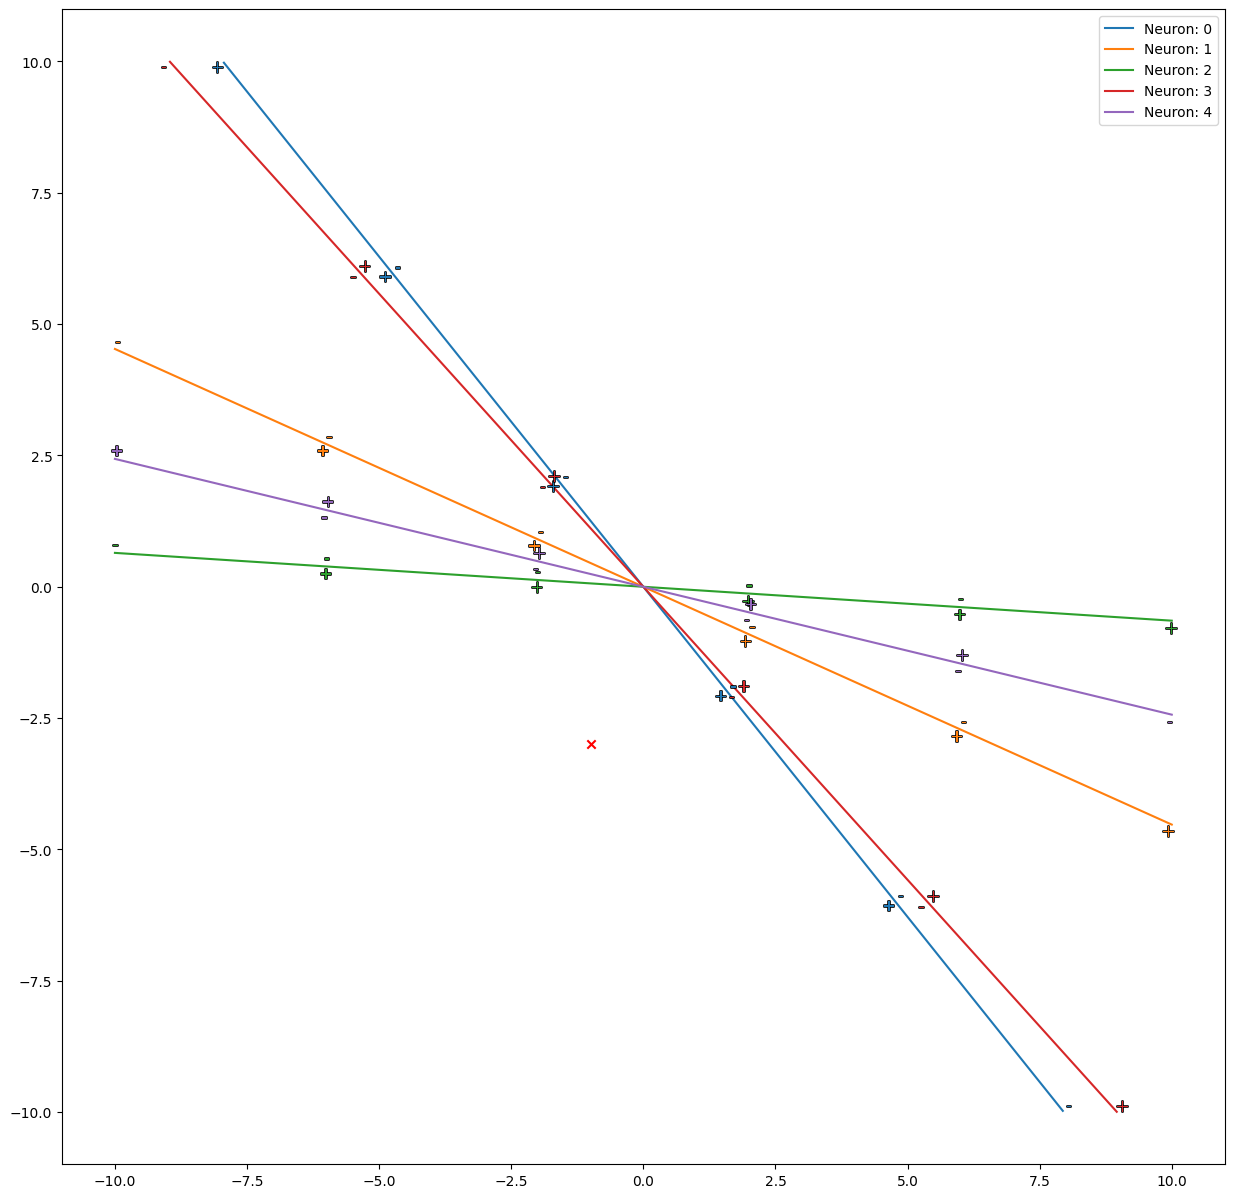

In [87]:
import matplotlib.patheffects as pe

x_min, x_max = -10, 10
y_min, y_max = -10, 10
colors = plt.cm.tab10.colors

def clip_to_bounds(x, y, x_min, x_max, y_min, y_max):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def plot_hyperplane(ax, w, b, color, label, offset=0.15, num_marks=6):
    """Plot a hyperplane with +/- markers."""
    if abs(w[1]) > 1e-6:
        x_vals = np.linspace(x_min, x_max, 1000)
        y_vals = -(w[0]*x_vals + b)/w[1]
        mask = (y_vals >= y_min) & (y_vals <= y_max)
        if np.any(mask):
            x_line, y_line = x_vals[mask], y_vals[mask]
            ax.plot(x_line, y_line, color=color, label=label)

            n = w / np.linalg.norm(w)
            ds = np.sqrt(np.diff(x_line)**2 + np.diff(y_line)**2)
            s = np.concatenate(([0], np.cumsum(ds)))
            s_targets = np.linspace(0, s[-1], num_marks)
            x_marks = np.interp(s_targets, s, x_line)
            y_marks = np.interp(s_targets, s, y_line)

            for xm, ym in zip(x_marks, y_marks):
                xp, yp = xm + offset*n[0], ym + offset*n[1]
                xm_, ym_ = xm - offset*n[0], ym - offset*n[1]
                if clip_to_bounds(xp, yp, x_min, x_max, y_min, y_max):
                    ax.text(xp, yp, '+', color=color, ha='center', va='center', fontsize=12,
                            path_effects=[pe.withStroke(linewidth=1.2, foreground="black")])
                if clip_to_bounds(xm_, ym_, x_min, x_max, y_min, y_max):
                    ax.text(xm_, ym_, '-', color=color, ha='center', va='center', fontsize=12,
                            path_effects=[pe.withStroke(linewidth=1.2, foreground="black")])
    else:
        x_line = -b/w[0]
        if x_min <= x_line <= x_max:
            ax.axvline(x_line, color=color, label=label)
            n = w / np.linalg.norm(w)
            y_marks = np.linspace(y_min, y_max, num_marks)
            for ym in y_marks:
                xp, yp = x_line + offset*n[0], ym
                xm_, ym_ = x_line - offset*n[0], ym
                if clip_to_bounds(xp, yp, x_min, x_max, y_min, y_max):
                    ax.text(xp, yp, '+', color=color, ha='center', va='center', fontsize=12,
                            path_effects=[pe.withStroke(linewidth=1.2, foreground="black")])
                if clip_to_bounds(xm_, ym_, x_min, x_max, y_min, y_max):
                    ax.text(xm_, ym_, '-', color=color, ha='center', va='center', fontsize=12,
                            path_effects=[pe.withStroke(linewidth=1.2, foreground="black")])
fig, ax = plt.subplots(figsize=(15,15))

# colors = ["r", "b", "g", "orange", "purple", "cyan"]
n = 0
for we, be in zip(W1, b1):
    plot_hyperplane(ax, we, be, color=colors[n], label=f"Neuron: {n}")
    n += 1
ax.legend()
ax.scatter(x0[0], x0[1], marker="x", color="r")

## Find $q_0$ - activation pattern of $x_0$

In [88]:
def find_activation_pattern(x, W, b, W_proj=None, b_proj=None):
    if W_proj is None and b_proj is None:
        z = W @ x + b
        return (z>0).astype(int)
    else:
        #FIXME
        pass
    
q0 = find_activation_pattern(x0, W1, b1)
q0

array([[1],
       [1],
       [1],
       [0],
       [0]])

## Find $\tilde{q_0}$ - Active bits of $q_0$

In [89]:
def get_signs_from_activation(activation: np.ndarray) -> np.ndarray:
    """Convert activation vector {0, 1} to sign vector {-1, 1}."""
    return -2 * activation + 1
s = get_signs_from_activation(q0)

In [90]:
ds = np.diag(s.squeeze())


In [91]:
import numpy as np
from scipy.optimize import linprog
import multiprocessing as mp


def _solve_single_lp(args):
    """
    Worker function: tests whether constraint i is non-redundant.
    Returns i if active, -1 otherwise.
    """
    i, A, c, tol = args

    n_constraints, d = A.shape
    a_i = A[i]

    A_tilde = np.delete(A, i, axis=0)
    c_tilde = np.delete(c, i, axis=0)

    bounds = [(None, None)] * d

    res = linprog(
        c=-a_i,
        A_ub=A_tilde,
        b_ub=c_tilde,
        bounds=bounds,
        method="highs",
    )

    if res.status == 3:  # unbounded
        return i


    max_val = -res.fun
    ci = c[i]

    if max_val > ci + tol:
        return i
    else:
        return -1


def find_active_bits_parallel(A, c, n_jobs=None, tol=1e-7, verbose=False):
    """
    Parallel version of find_active_bits using scipy.linprog (HiGHS).
    """

    A = np.asarray(A)
    c = np.asarray(c).reshape(-1)

    n_constraints = A.shape[0]

    if n_jobs is None:
        n_jobs = mp.cpu_count()

    tasks = [(i, A, c, tol) for i in range(n_constraints)]

    active_bits = []

    with mp.Pool(processes=n_jobs) as pool:
        for k, res in enumerate(pool.imap_unordered(_solve_single_lp, tasks)):
            if res != -1:
                active_bits.append(res)

            if verbose and (k + 1) % 250 == 0:
                print(f"Processed {k + 1}/{n_constraints}")

    return np.array(sorted(active_bits))


q0_tilde = find_active_bits_parallel(ds @ W1, ds @ (-b1), n_jobs=8, verbose=True)
q0_tilde

array([0, 2])

## Iterate through active bits and accumulate neighbours